In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00


In [3]:
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
#np.random.seed = 42
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
root_dir = '/content/drive/MyDrive/input/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['.DS_Store', 'malignant', 'normal', 'benign']

In [5]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

In [6]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.uint8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [7]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

100%|██████████| 266/266 [00:04<00:00, 57.50it/s] 


In [9]:
print(x_benign.shape, y_benign.shape, type(x_benign), type(x_benign))
print(x_malignant.shape, y_malignant.shape, type(x_malignant), type(y_malignant))
print(x_normal.shape, y_normal.shape, type(x_normal), type(y_normal))

(437, 128, 128, 3) (437, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(215, 128, 128, 3) (215, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(133, 128, 128, 3) (133, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

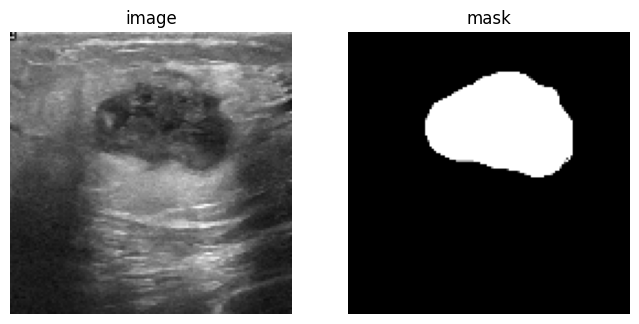

In [11]:
## displaying data loaded by our function
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(X[529], cmap='gray')
plt.title('image')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(y[529]), cmap='gray')
plt.title('mask')
plt.axis('off');

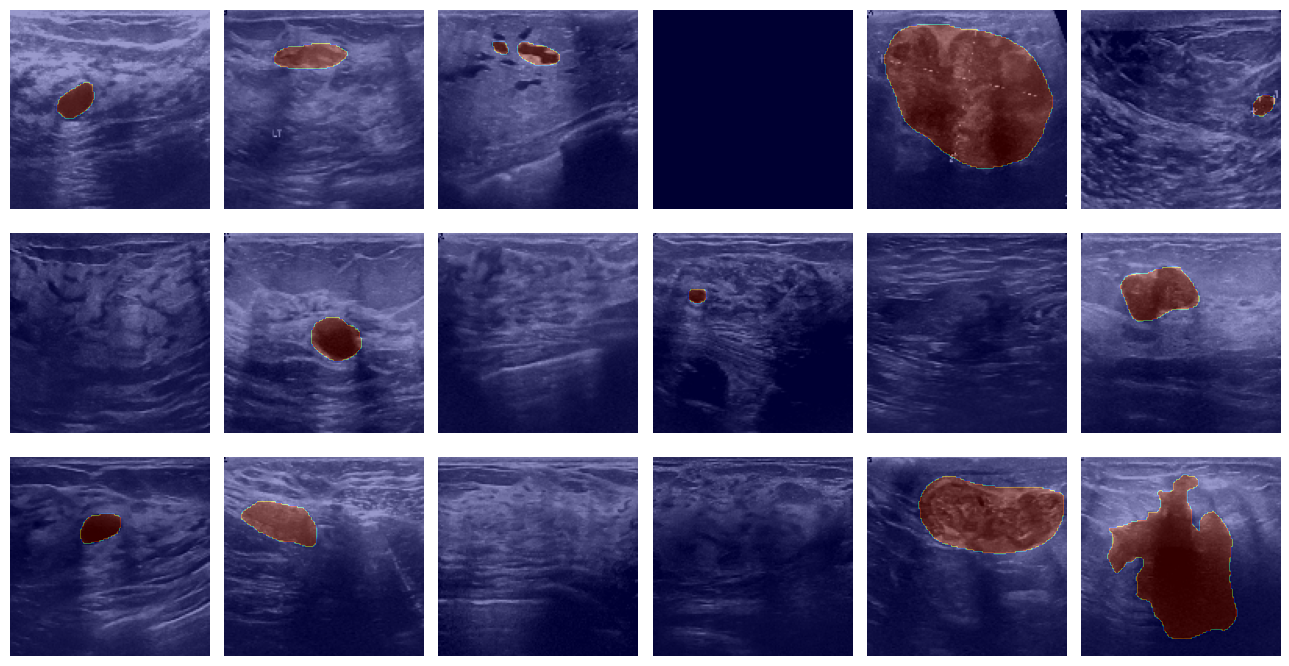

In [12]:
#origonal plot
plt.figure(figsize=(13,7))
for i in range(18):
    plt.subplot(3,6,i+1)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.imshow(tf.squeeze(y[idx]), cmap='jet', alpha=0.4)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
X_norm = X / 255
y_norm = y / 255

In [14]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_norm,
                                 y_norm, 
                                 test_size=0.1,
                                 random_state=11,
                                 #stratify=y_norm
                                 )
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                            y_train_val,
                            test_size=0.1,
                            random_state=11,
                            #stratify=y_train_val
                            )

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((635, 128, 128, 3),
 (635, 128, 128, 1),
 (71, 128, 128, 3),
 (71, 128, 128, 1),
 (79, 128, 128, 3),
 (79, 128, 128, 1))

In [15]:
# RGB transform Gray
X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)
X_val = tf.image.rgb_to_grayscale(X_val)
type(X_train)
#Out[85]: tensorflow.python.framework.ops.EagerTensor
print(X_train.shape, X_test.shape, X_val.shape)
#(439, 224, 224, 1) (236, 224, 224, 1) (110, 224, 224, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
type(X_train)
#Out[87]: numpy.ndarray

(635, 128, 128, 1) (79, 128, 128, 1) (71, 128, 128, 1)


numpy.ndarray

In [20]:
from tensorflow import keras
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, concatenate, MaxPooling2D, BatchNormalization, Activation

In [34]:
inputs = Input((128, 128, 1))

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)


c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

outly = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)
model = Model(inputs=inputs, outputs=outly, name='U-net')

model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 128, 128, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_99 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_98[0][0]']              
                                )                                                             

In [35]:
def dice_coef(y_test, y_pred):
  smooth = 1
  y_test_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_test_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_test_f * y_test_f) + K.sum(y_pred_f * y_pred_f) + smooth)


In [36]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0003), loss='binary_crossentropy', metrics=[dice_coef])

In [37]:
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50)

Epoch 1/50
40/40 [==============================] - 44s 520ms/step - loss: 0.3944 - dice_coef: 0.1526 - val_loss: 0.2844 - val_dice_coef: 0.3502
Epoch 2/50
40/40 [==============================] - 11s 264ms/step - loss: 0.2572 - dice_coef: 0.3014 - val_loss: 0.2168 - val_dice_coef: 0.4603
Epoch 3/50
40/40 [==============================] - 11s 267ms/step - loss: 0.2346 - dice_coef: 0.3623 - val_loss: 0.2433 - val_dice_coef: 0.3453
Epoch 4/50
40/40 [==============================] - 11s 266ms/step - loss: 0.2110 - dice_coef: 0.4169 - val_loss: 0.2129 - val_dice_coef: 0.4791
Epoch 5/50
40/40 [==============================] - 11s 267ms/step - loss: 0.1896 - dice_coef: 0.4911 - val_loss: 0.2367 - val_dice_coef: 0.4946
Epoch 6/50
40/40 [==============================] - 11s 268ms/step - loss: 0.1779 - dice_coef: 0.5315 - val_loss: 0.2203 - val_dice_coef: 0.5112
Epoch 7/50
40/40 [==============================] - 11s 269ms/step - loss: 0.1693 - dice_coef: 0.5548 - val_loss: 0.1851 - val_dic

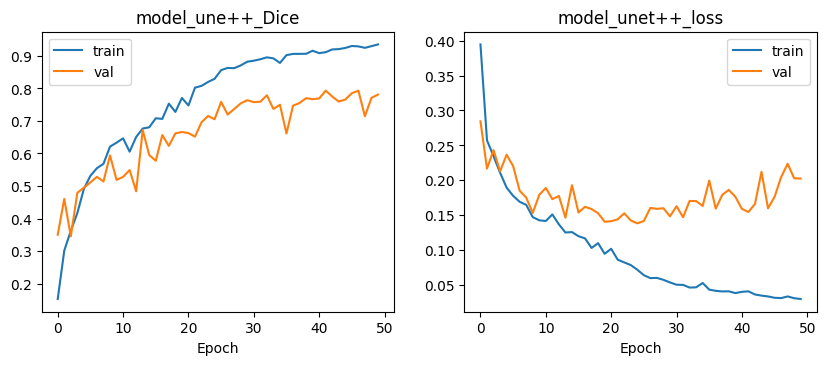

In [38]:
#model_unet
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model_une++_Dice')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model_unet++_loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

In [39]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test dice', score[1])

3/3 [==============================] - 8s 2s/step - loss: 0.2964 - dice_coef: 0.7896
Test loss:  0.2964124083518982
Test dice 0.7895883917808533


In [40]:
pred = model.predict(X_test)
pred[pred>=0.5]=1
pred[pred<=0.5]=0

3/3 [==============================] - 1s 157ms/step


Text(0.5, 1.0, 'image')

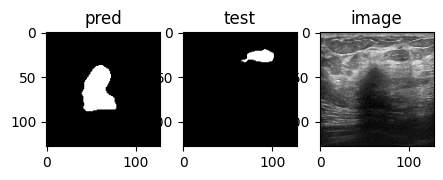

In [41]:
i=8
plt.figure(figsize=(5, 8))
plt.subplot(1, 3, 1)
plt.imshow(pred[i], cmap='gray')
plt.title("pred")
plt.subplot(1, 3, 2)
plt.imshow(y_test[i], cmap='gray')
plt.title("test")
plt.subplot(1, 3, 3)
plt.imshow(X_test[i], cmap='gray')
plt.title("image")


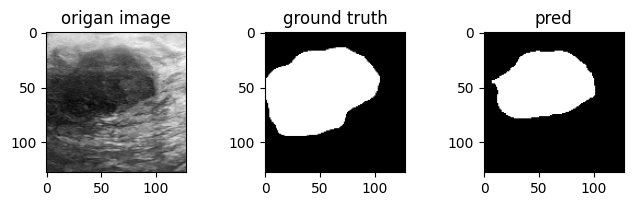

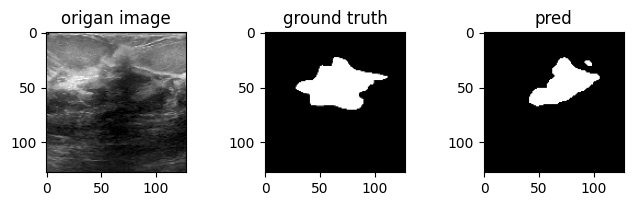

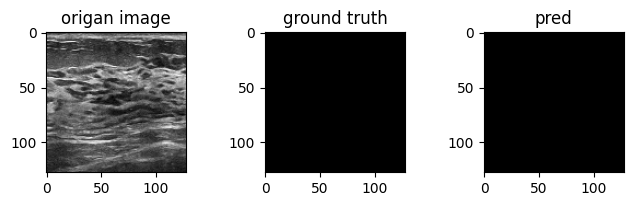

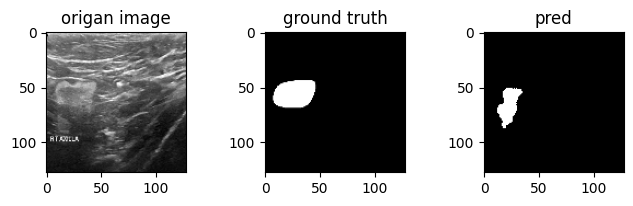

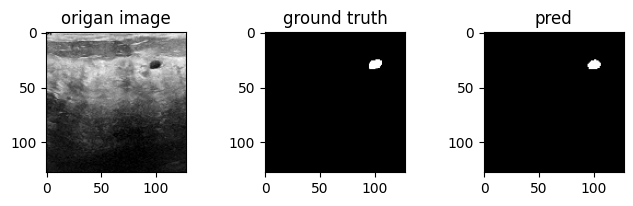

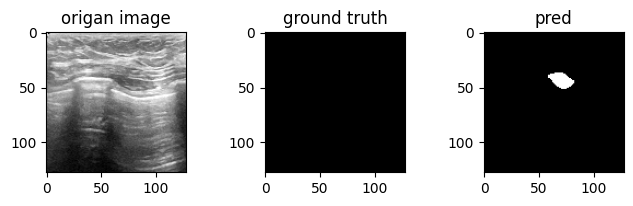

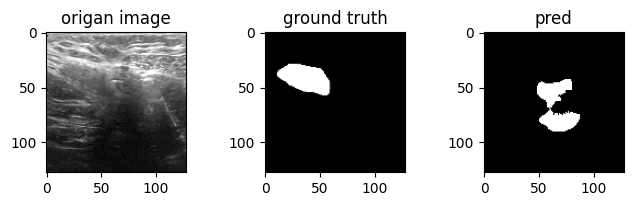

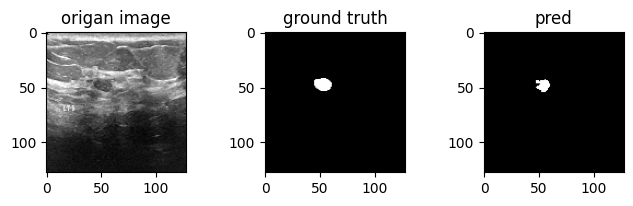

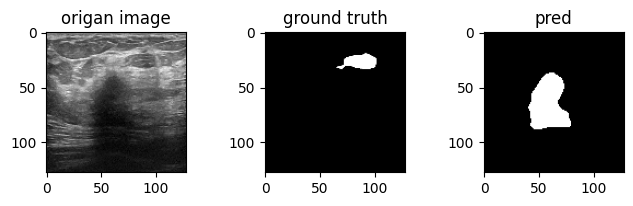

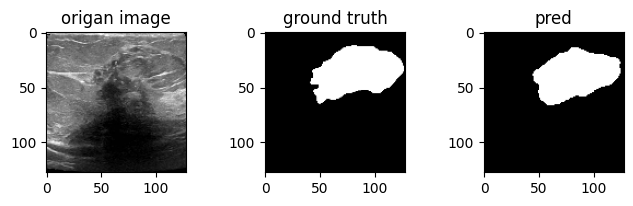

In [42]:
for i in range(10):
  plt.figure(figsize=(8, 4))
  plt.subplot(2, 3, 1)
  plt.title("origan image")
  plt.imshow(X_test[i], cmap='gray')
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(y_test[i], cmap='gray')
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(pred[i], cmap='gray')
  plt.show()